### Code used for single cell data analysis and generation of anndata object
_Inhibition of LTβR-signalling blocks epithelial apoptosis and activates Wnt-induced regeneration in lung_ <br> Thomas M Conlon, Mathias Heikenwälder et. al and Ali Yildirim

In [1]:
## This Notebook generates anndata object used in other Notebooks, and Figure 1 h, i j

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
folder = "20200525_Yildirim_6mSmokedMiceLTbeta_meshal.ansari/"

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 3
sc.logging.print_version_and_date()

Running Scanpy 1.5.2.dev28+gb910afc6, on 2020-07-06 13:07.


### Read in Data Files

In [2]:
## Read in filtered Raw Count Matrix
adata = sc.read(folder + "LTbetaTreatment_raw_counts.mtx")
adata.obs_names = pd.read_csv(folder + "LTbetaTreatment_barcodes.txt", header = None).iloc[:, 0].values
adata.var_names = pd.read_csv(folder + "LTbetaTreatment_genes.txt", header = None).iloc[:, 0].values

## Meta Data
adata.obs = pd.read_csv(folder + "LTbetaTreatment_cells_metadata.txt", sep = "\t", index_col = 0)
sc._utils.sanitize_anndata(adata)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


... storing 'Sample_ID' as categorical
... storing 'Air' as categorical
... storing 'Condition' as categorical
... storing 'Celltype' as categorical


In [3]:
adata

AnnData object with n_obs × n_vars = 21413 × 25095
    obs: 'Sample_ID', 'Air', 'Condition', 'Louvain_Cluster', 'Celltype', 'Positive_Regulation_of_NIK_Score (GO:1901224)', 'Hallmark_Apoptosis_Score', 'Axin2_counts', 'Tcf4_counts', 'size_factors', 'percentage_mito', 'total_counts', 'total_genes'

In [4]:
print(adata.obs_names[:10].values)
print(adata.var_names[:10].values)
adata.X[5:10, :10].todense()

['muc14440_AACTTTTCCATC' 'muc14440_CATCCCCACGAA' 'muc14440_TGGCGTACGACG'
 'muc14440_CGCACGCCGTTT' 'muc14440_CGTTACCCTCGG' 'muc14440_GAGCCCTAATTT'
 'muc14440_TAGGAACCTTTA' 'muc14440_ATGTGCCCGTTT' 'muc14440_GAATCAATGTAG'
 'muc14440_ACCGCGGGAGTT']
['0610005C13Rik' '0610009B22Rik' '0610009E02Rik' '0610009L18Rik'
 '0610010F05Rik' '0610010K14Rik' '0610012G03Rik' '0610025J13Rik'
 '0610030E20Rik' '0610038B21Rik']


matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Normalization and Log Transformation

In [5]:
from scipy import sparse

## Keep the count data in a counts layer
adata.layers["counts"] = sparse.csr_matrix(adata.X.copy())

## Normalize adata and Log Transform
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

## Store the full data set in 'raw' as log-normalized data
adata.raw = sc.AnnData(X = sparse.csr_matrix(adata.X))
adata.raw.var.index = adata.var_names.copy()

### Variable Gene Selection

extracting highly variable genes
    finished (0:00:12)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


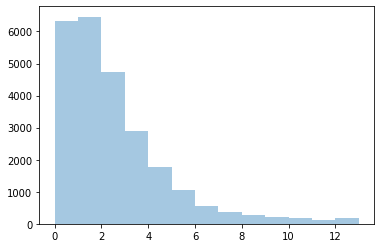

In [6]:
batch = "Sample_ID"
sc.pp.highly_variable_genes(adata, min_disp = None, max_disp = None, min_mean = None, max_mean = None, 
                            batch_key = batch, n_top_genes = 4000, flavor = "cell_ranger", subset = False)

vartab = pd.DataFrame(adata.var["highly_variable_nbatches"], index = adata.var_names)
sb.distplot(vartab, kde = False, bins = len(np.unique(adata.obs[batch])))

In [7]:
thresh = 3
hvgs = vartab[vartab.highly_variable_nbatches.values >= thresh].index
print("%s Genes kept, variable in at least %s samples" %(len(hvgs), thresh))

7664 Genes kept, variable in at least 3 samples


In [8]:
## Remove ambient genes from this list
ambis = pd.read_csv(folder + "ambients.txt", header = None)
ambis = [a for a in np.unique(ambis) if not a.startswith("muc")]

## Remove cell cycle genes from list - Mouse
cc_genes = [x.strip().capitalize() for x in open(folder + "regev_lab_cell_cycle_genes.txt")]
remove = np.unique(np.concatenate([ambis, cc_genes]))
hvgs = np.setdiff1d(hvgs, remove)

In [9]:
adata.var["highly_variable"] = [g in hvgs for g in adata.var_names]
sum(adata.var["highly_variable"])

7572


In [10]:
## Set it based on list to be consistent
hvgs = pd.read_csv(folder + "LTbetaTreatment_variable_genes.txt", header = None).iloc[:, 0].values
adata.var["highly_variable"] = [g in hvgs for g in adata.var_names]
sum(adata.var["highly_variable"])

7572

### Calculate cell cycle Score and Regression

In [11]:
## Mouse
cc_genes = [x.strip().capitalize() for x in open(folder + "for_orientation/regev_lab_cell_cycle_genes.txt")]
s_genes = cc_genes[:43]
g2m_genes = cc_genes[43:]
cc_genes = np.intersect1d(adata.var_names, cc_genes)
sc.tl.score_genes_cell_cycle(adata, s_genes = s_genes, g2m_genes = g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    601 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    601 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [13]:
sc.pp.filter_genes(adata, min_counts = 1)
sc.pp.regress_out(adata, ['percentage_mito', 'S_score', 'G2M_score'])

filtered out 50 genes that are detected in less than 1 counts
regressing out ['percentage_mito', 'S_score', 'G2M_score']
	finished (0:18:01)


### Dimensionality Reduction and Visualization

In [14]:
sc.set_figure_params(vector_friendly = True)
plt.rcParams["figure.figsize"] = (6, 5)

sc.pp.pca(adata, n_comps = 60, use_highly_variable = True)
sc.pp.neighbors(adata, n_pcs = 50, n_neighbors = 10)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=60
    finished (0:00:44)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


... storing 'phase' as categorical


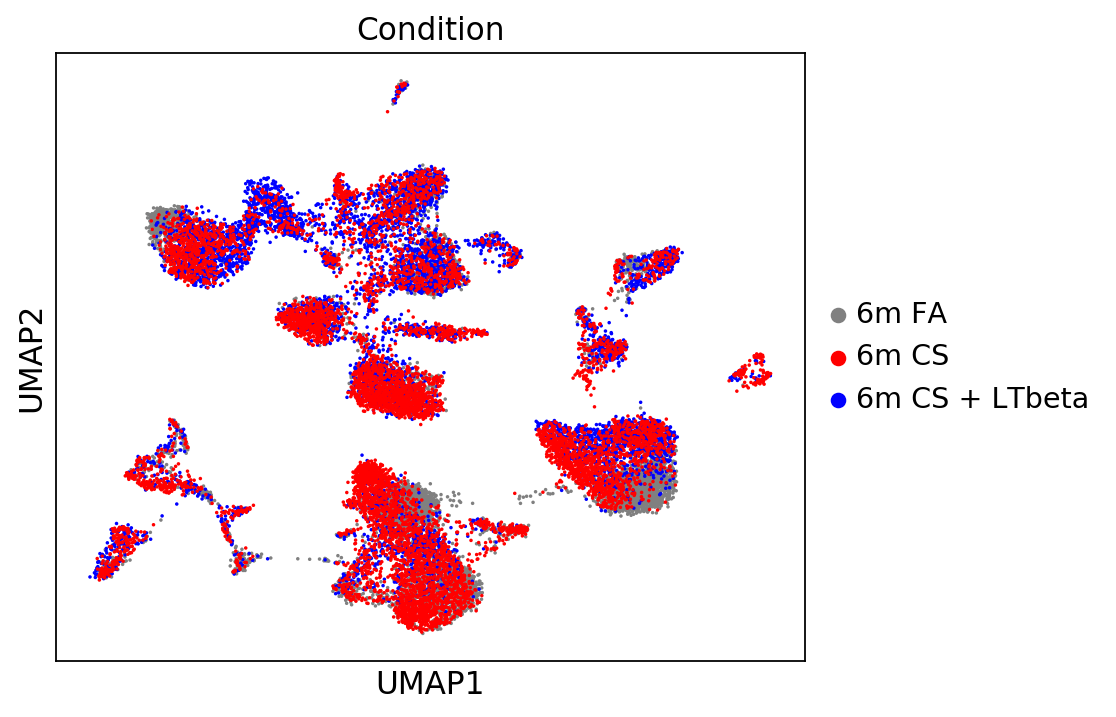

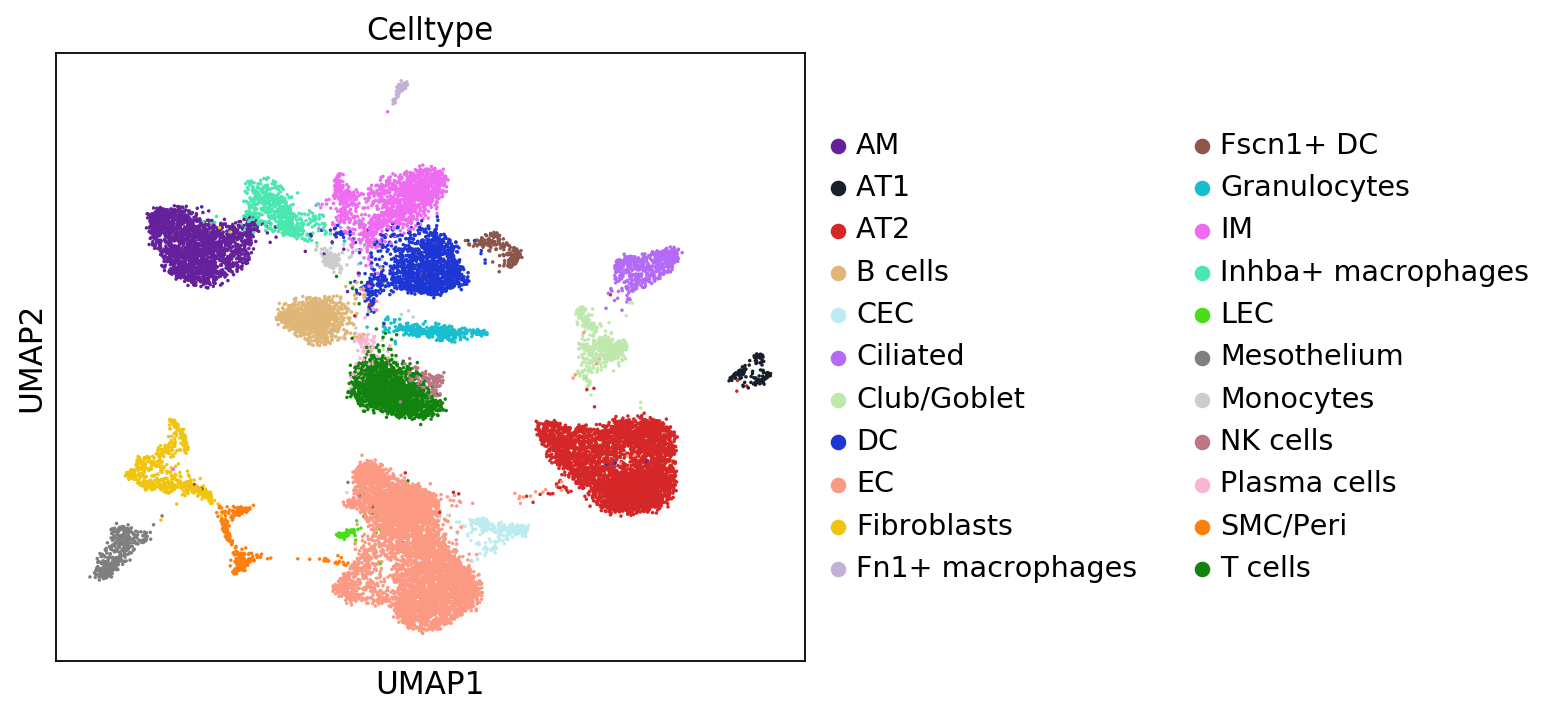

In [15]:
## Set it based on coordinates to be consistend with figures
adata.obsm["X_umap"] = pd.read_csv(folder + "LTbetaTreatment_umap_coords.txt", sep = "\t", index_col = 0).values

## Set colours
adata.obs["Condition"].cat.reorder_categories(["6m FA", "6m CS", "6m CS + LTbeta"], inplace = True)
condition_colors = ["gray", "red", "blue"]
ct_colors = ["#65209B", "#17202A", "#d62728", "#DFB678", "#BDECF0", "#B36BF6", "#BFE9AC", "#1E37D4", 
             "#FC9983", "#F1C40F", "#c5b0d5", "#8c564b", "#17becf", "#EF6BF1", "#4BE7B0", "#49de16", 
             "#7f7f7f", "#CCCCCC", "#bb7784", "#f7b6d2", "#ff7f0e", "#138310"]

sc.pl.umap(adata, color = "Condition", palette = condition_colors, size = 10)
sc.pl.umap(adata, color = "Celltype", palette = ct_colors, size = 10)

### Feature Plots

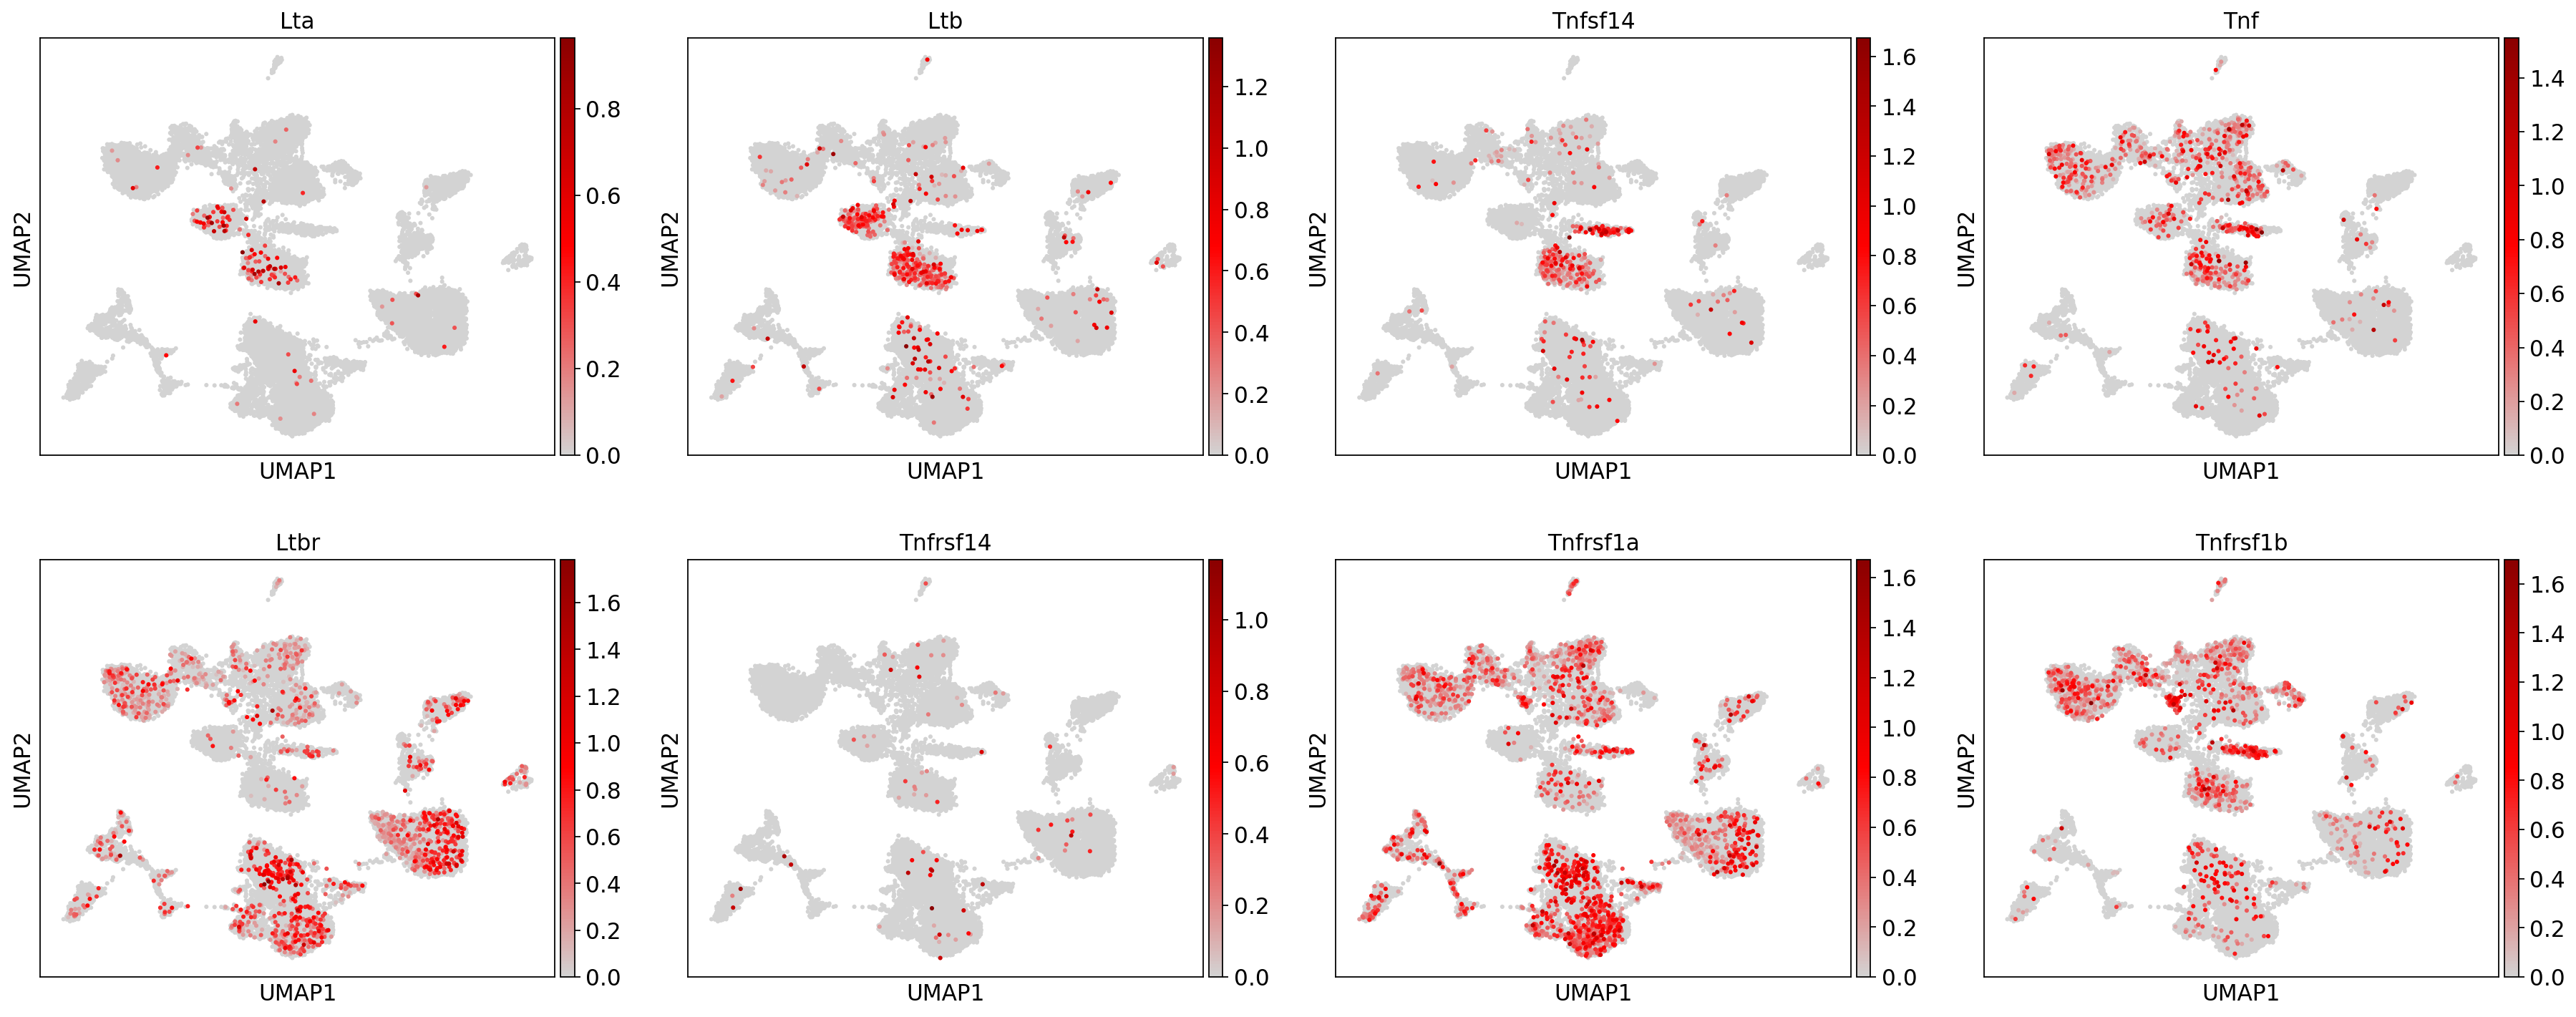

In [16]:
from matplotlib import colors
col = ["lightgray", "red", "darkred"] 
gray_red = colors.LinearSegmentedColormap.from_list("grouping", col, N = 128)

genes = ["Lta", "Ltb", "Tnfsf14", "Tnf",  "Ltbr", "Tnfrsf14", "Tnfrsf1a", "Tnfrsf1b"]
sc.pl.umap(adata, color = genes, cmap = gray_red, size = 30)